In [1]:
import pandas as pd

# Load the datasets
tracks_df = pd.read_csv('Data/29_tracks.csv')
book_df = pd.read_csv('Data/Book1.csv')

# Preprocess track IDs in Book1.csv to handle multiple IDs in a single cell
expanded_rows = []
for index, row in book_df.iterrows():
    track_ids = str(row['trackId']).split(',')
    for track_id in track_ids:
        expanded_rows.append({
            'trackId': int(track_id.strip()),
            'initial_frame': row['initial_frame'],
            'ending_frame': row['ending_frame']
        })

# Convert the expanded list into a DataFrame
book_expanded_df = pd.DataFrame(expanded_rows)

# Create a mapping from the book dataframe
range_mapping = {}
for _, row in book_expanded_df.iterrows():
    if row['trackId'] not in range_mapping:
        range_mapping[row['trackId']] = []
    range_mapping[row['trackId']].append((row['initial_frame'], row['ending_frame']))

# Label the tracks DataFrame
def label_stopped(row):
    if row['trackId'] in range_mapping:
        for frame_range in range_mapping[row['trackId']]:
            if frame_range[0] <= row['frame'] <= frame_range[1]:
                return 1
    return 0

tracks_df['stopped_before_pedestrian'] = tracks_df.apply(label_stopped, axis=1)

# Save the updated dataframe
tracks_df.to_csv('Data/29_tracks_labeled.csv', index=False)

stopped_track_ids = tracks_df[tracks_df['stopped_before_pedestrian'] == 1]['trackId'].unique()

print(stopped_track_ids)


[ 90 103 146 160 162 228 241 243 244 268 273 277 290 352 368 372 419 426
 427 428 474 500 505 512 514 515 523 538 541 549]


Epoch 1/4


2024-05-06 18:01:05.723043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 18:01:05.892361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


    6/20917 [..............................] - ETA: 3:38 - loss: 0.3466 - accuracy: 0.5312   

2024-05-06 18:01:06.078075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20917/20917 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9088

2024-05-06 18:03:55.676264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 18:03:55.733267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20917/20917 [==============================] - 189s 9ms/step - loss: 0.1830 - accuracy: 0.9088 - val_loss: 0.1510 - val_accuracy: 0.9366
Epoch 2/4
20917/20917 [==============================] - 186s 9ms/step - loss: 0.1085 - accuracy: 0.9418 - val_loss: 0.1158 - val_accuracy: 0.9563
Epoch 3/4
20917/20917 [==============================] - 197s 9ms/step - loss: 0.0900 - accuracy: 0.9550 - val_loss: 0.1272 - val_accuracy: 0.9552
Epoch 4/4
  46/6537 [..............................] - ETA: 14s 

2024-05-06 18:13:44.199565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 18:13:44.243365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6537/6537 [==============================] - 16s 2ms/step


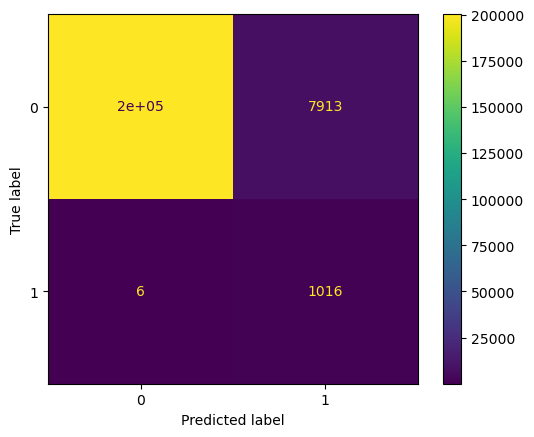

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('Data/29_tracks_labeled.csv')

# Assuming '29_tracks.csv' has been properly labeled and contains the 'stopped_before_pedestrian' column
features = data[['xCenter', 'yCenter', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration']]
labels = data['stopped_before_pedestrian']

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Reshape data for LSTM: [samples, time_steps, features]
# This is an example; you might need to adjust time_steps based on your actual data organization
features = features.reshape((data.shape[0], 1, features.shape[1]))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(features.shape[1], features.shape[2])),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=4, batch_size=32, validation_split=0.2 , class_weight=class_weight_dict)

# Predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
